# TP – Optimisation: Julien Blanchon

L’objectif de ces 2 TP d’optimisation est de programmer les méthodes de Gauß-Newton (voir
page 58 du polycopié sous Moodle) et de Newton (voir page 57 du polycopié sous Moodle) pour
un problème aux moindres carrés: 
$$(\mathcal{P})\left\{\begin{array}{l}
\operatorname{Min} f(\beta)=\frac{1}{2}\|r(\beta)\|^{2} \\
\beta \in \mathbb{R}^{p}
\end{array}\right.$$

où r est la fonction résidus

$$\begin{aligned}
r: \quad \mathbb{R}^{p} & \longrightarrow \mathbb{R}^{n} \\
\beta & \longmapsto r(\beta)
\end{aligned}$$
On note $\beta^{(0)}$ le point initial et $\beta^{(k)}$ l'itéré courant. On pose aussi Tol_rel et Tol_abs $=\sqrt{\varepsilon_{\text {mach}}}$ (sqrt(eps) en Matlab). Les tests d'arrêt seront les suivants :
1. $\left\|\nabla f\left(\beta^{(k+1)}\right)\right\|$ petit $:\left\|\nabla f\left(\beta^{(k+1)}\right)\right\| \leq \max \left(\right.$ Tol_rel $\left\|\nabla f\left(\beta^{(0)}\right)\right\|,$ Tol_als $)$
2. Évolution de $f\left(\beta^{(k+1)}\right)$ petit $:\left|f\left(\beta^{(k+1)}\right)-f\left(\beta^{(k)}\right)\right| \leq \max \left(\right.$ Tol_rel $\left|f\left(\beta^{(k)}\right)\right|$, Tol_als $)$
3. Évolution du pas $\delta^{(k)}=\beta^{(k+1)}-\beta^{(k)}$ petit $:\left\|\beta^{(k+1)}-\beta^{(k)}\right\| \leq \max \left(\right.$ Tol_rel $\left\|\beta^{(k)}\right\|,$ Tol_als $)$
4. Le nombre d'itération maximal est atteint.


$$A(t)=A_{0} e^{-\lambda t}$$

$$\begin{array}{||c|ccccccc||}
\hline \hline t & 500 & 1000 & 2000 & 3000 & 4000 & 5000 & 6300 \\
\hline A & 14.5 & 13.5 & 12.0 & 10.8 & 9.9 & 8.9 & 8.0 \\
\hline \hline
\end{array}$$

In [50]:
format long g

## Programme Principale

In [59]:
%%file Modelisation_C14.m

%-------------------------------------------------------------------------%
% 1SN - TP Optimisation                                                   %
% INP Toulouse - ENSEEIHT                                                 %
% Novembre 2020                                                           %
%                                                                         %
% Ce fichier contient le programme principal permettant l'estimation      %
% des parametres de la fonction de desintegration radioactive du          %
% carbone 14 par une approche des moindres carres.                        %                                      %
% Modele : A(t)= A0*exp(-lambda*t)                                        %
% Les algorithmes utilises pour la minimisation sont :                    %
% - l'algorithme de Gauss-Newton                                          %
% - l'algorithme de Newton.                                               %
%-------------------------------------------------------------------------%

clear
close all
clc
format shortG
taille_ecran = get(0,'ScreenSize');
L = taille_ecran(3);
H = taille_ecran(4);

% Initialisation

% Donnees
if exist('C14_results.txt','file')
    delete('C14_results.txt');
end
diary C14_results.txt
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];

% Estimation a priori des parametres du modele : beta0 = [A0, lambda]
beta0 = [10; 0.0001];   % Newton, Gauus-Newton, fminunc et leastsq converge
% beta0 = [15; 0.001];    % Newton, Gauss-Newton, fminunc et leastsq divergent
% beta0 = [15; 0.0005];   % Newton diverge, Gauss-Newton, fminunc et leastsq convergent
% beta0 = [10; 0.0005];   % Gauss-Newton converge

%% Calcul et affichage du modele initial ----------------------------------
xmin = 9; xmax = 20;
x = linspace(xmin, xmax, 100);

ymin = -0.0001; ymax = 0.0005;
y = linspace(ymin, ymax, 100);

[A0_plot, lambda_plot] = meshgrid(x, y);
[m , n] = size(A0_plot);
f_plot = zeros(m, n);

for i = 1:m
   for j = 1:n
      res_plot = residu_C14([A0_plot(i,j); lambda_plot(i,j)], Donnees);
      %%%%%%%%%
      f_plot(i,j) = 0.5*res_plot'*res_plot;
      %%%%%%%%%
   end
end

figure('Position',[0.1*L,0.1*H,0.8*L,0.8*H]); 
subplot(1,3,1) % Fonction f en 3D
    mesh(A0_plot, lambda_plot, f_plot)
    axis('square')
    title('Representation de la fonction f des moindres carres')
    xlabel('A_0');
    ylabel('\lambda')
    zlabel('f(A_0,\lambda)')

T = linspace(0,6500,100);
A = beta0(1)*exp(-beta0(2)*T);
txt_legend{1} = 'donnees';
txt_legend{2} = 'depart';

subplot(2, 3, 2) % Donnees + modele initial pour Gauss-Newton
    title('Desintegration radioactive du carbone 14 (Gauss-Newton)')
    axis([0 max(T) 0 18])
    xlabel('dur�e T')
    ylabel('radioactivit� A')
    hold on
    grid on
    plot(Ti, Ai, 'ok')
    plot(T, A)
    legend(txt_legend{1:2}, 'Location', 'SouthWest')

subplot(2, 3, 5) % Courbes de niveaux de f pour Gauss-Newton
    title('Recherche des parametres (Gauss-Newton)')
    xlabel('A_0')
    ylabel('\lambda')
    hold on
    contour(A0_plot, lambda_plot, f_plot, 100);
    plot(beta0(1),beta0(2),'ok')
    text(beta0(1),beta0(2),'  depart \beta^{(0)}')
    
subplot(2, 3, 3) % Donnees + modele initial pour Newton
    title('Desintegration radioactive du carbone 14 (Newton)')
    axis([0 max(T) 0 18])
    xlabel('dur�e T')
    ylabel('radioactivit� A')
    hold on
    grid on
    plot(Ti, Ai, 'ok')
    plot(T, A)
    legend(txt_legend{1:2}, 'Location', 'SouthWest')

subplot(2, 3, 6) % Courbes de niveaux de f pour Newton
    title('Recherche des parametres (Newton)')
    xlabel('A_0')
    ylabel('\lambda')
    hold on
    contour(A0_plot, lambda_plot, f_plot, 100);
    plot(beta0(1),beta0(2),'ok')
    text(beta0(1),beta0(2),'  depart \beta^{(0)}')

pause(0.5)

%% Algorithmes
% Choix du nombre d'iteration maximal

nb_iterations_max = 8;
txt_legend = cell(1,nb_iterations_max+2);
txt_legend{1} = 'donnees';
txt_legend{2} = 'depart';


%% Gauss-Newton
% -------------
% Initialisation de l'affichage
disp('Algorithme de Gauss-Newton')
disp('--------------------------------------------------------------------------------------------')
disp('     nb_iter         A0        lambda    ||f''(beta)||     f(beta)    ||delta||     exitflag ')
disp('--------------------------------------------------------------------------------------------')

% Calcul et affichage des valeurs initiales
res_beta = residu_C14(beta0, Donnees);
f_beta = 0.5*(res_beta.')*res_beta;
J_res_beta = J_residu_C14(beta0, Donnees);
norm_grad_f_beta = norm((J_res_beta.')*res_beta);
disp([0 beta0(1) beta0(2) norm_grad_f_beta f_beta]);

options = [sqrt(eps) 1.e-12 0];

for i = 1:nb_iterations_max
    txt_legend{i+2} = ['iterat� ' num2str(i)];
	options(3) = i;
	[beta, norm_grad_f_beta, f_beta, norm_delta, k, exitflag] = ...
	Algo_Gauss_Newton(@(beta) residu_C14(beta, Donnees), ...
                      @(beta) J_residu_C14(beta, Donnees), ...
                      beta0, options);
	disp([k beta(1) beta(2) norm_grad_f_beta f_beta norm_delta exitflag])
    % Visualisation
    A = beta(1)*exp(-beta(2)*T);
	subplot(2, 3, 2)
	plot(T,A)
    legend(txt_legend{1:i+2})
    %  eval(['print -depsc fig_GN_courbe' int2str(i) '_C14'])
	subplot(2, 3, 5)
    plot(beta(1),beta(2),'ok')
	text(beta(1),beta(2),['  \beta^{(' num2str(i) ')}'])
  
	pause(0.5)
end

% Affichage des itérés de beta et sauvegarde des graphique
disp('--------------------------------------------------------------------------------------------')

%% Newton
% -------
% Initialisation de l'affichage
disp('Algorithme de Newton')
disp('--------------------------------------------------------------------------------------------')
disp('     nb_iter         A0        lambda    ||f''(beta)||     f(beta)    ||delta||     exitflag ')
disp('--------------------------------------------------------------------------------------------')

% Calcul et affichage des valeurs initiales
res_beta = residu_C14(beta0, Donnees);
f_beta = 0.5*(res_beta.')*res_beta;
J_res_beta = J_residu_C14(beta0, Donnees);
norm_grad_f_beta = norm((J_res_beta.')*res_beta);
disp([0 beta0(1) beta0(2) norm_grad_f_beta f_beta]);

options = [sqrt(eps) 1.e-12 0];

for i = 1:nb_iterations_max
    options(3) = i;
    % Algorithme de Newton
    [beta, norm_grad_f_beta, f_beta, norm_delta, k, exitflag] = ...
    Algo_Newton(@(beta) Hess_f_C14(beta, Donnees, ...
                                   @(beta) residu_C14(beta, Donnees), ...
                                   @(beta) J_residu_C14(beta, Donnees)), ...
                beta0, options);
    % Affichage des valeurs
    disp([k beta(1) beta(2) norm_grad_f_beta f_beta norm_delta exitflag])
    % Visualisation
    A = beta(1)*exp(-beta(2)*T);
    subplot(2, 3, 3)
    plot(T,A)
    legend(txt_legend{1:i+2})
    subplot(2, 3, 6)
    plot(beta(1),beta(2),'ok')
	text(beta(1),beta(2),['  \beta^{(' num2str(i) ')}'])
  
	pause(0.5)
end

% Affichage des iteres de beta et sauvegarde des courbes
disp('--------------------------------------------------------------------------------------------')
print('C14_figures','-dpng')
diary

%% Fonctions a coder : residu, Jacobienne, Hessienne

%%------------------------------------------------------------------------%                                                                     %
% Fonction de calcul du residu de la fonction de desintegration           %
% radioactive du carbone 14                                               %
%-------------------------------------------------------------------------%
function res = residu_C14(beta, donnees)
%
% Paramètres en entrés
% --------------------
% beta : vecteur des paramètres
%         real(p)
% donnees : Données
%           real(n,2)
%
% Paramètres en sortie
% --------------------
% res    : vecteur des résidus
%          real(n)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    res = Ai - A0*exp(-lambda*ti);
end

%-------------------------------------------------------------------------%                                                                        %
% Fonction de calcul de la Jacobienne du residu de la fonction de         %
% desintegration radioactive du carbone 14                                %
%-------------------------------------------------------------------------%
function J_res = J_residu_C14(beta, donnees)
%
% Paramètres en entrés
% --------------------
% beta : vecteur des paramètres
%         real(p)
% donnees : Données
%           real(n,2)
%
% Paramètres en sortie
% --------------------
% J_res    : Matrice jacobienne des résidus
%            real(n,p)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    J_res(:, 1) = -exp(-lambda*ti);
    J_res(:, 2) = A0*ti.*exp(-lambda*ti);
end

%-------------------------------------------------------------------------%
% Fonction de calcul de la Hessienne des moindres carres de la fonction   %
% de desintegration radioactive du carbone 14                             %
% (residu et J_residu sont des fonctions en entree)                       %
%-------------------------------------------------------------------------%

function [H_f, res, J_res] = Hess_f_C14(beta, donnees, residu, J_residu)
%
% Paramètres en entrés
% --------------------
% beta     : vecteur des paramètres
%            real(p)
% donnees  : Données
%            real(n,2)
% residu   : fonction qui code les résidus
%            res = residus(beta)
% J_residu : fonction qui code la matrice jacobienne
%            J_res = J_residu(beta);
%
% Paramètres en sortie
% --------------------
% H_f      : Matrice hessienne
%            real(p,p)
% res      : vecteur des résidus
%            real(n)
% J_res    : Matrice jacobienne des résiduis
%            real(n,p)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    res = residu(beta);
    J_res = J_residu(beta);
    H_f(1, 1) = sum( (-exp(-lambda*ti)).*(-exp(-lambda*ti)) ); %lambda*lambda
    H_f(1, 2) = sum( (ti.*exp(-lambda*ti).*(Ai - A0*exp(-lambda*ti))) + (-exp(-lambda*ti).*(A0*ti.*exp(-lambda*ti))) ); %lambda*A0
    H_f(2, 1) = H_f(1, 2); %A0*lambda
    H_f(2, 2) = sum( (-A0*ti.*ti.*exp(-lambda*ti)).*(Ai - A0*exp(-lambda*ti)) + (A0*ti.*exp(-lambda*ti)).*(A0*ti.*exp(-lambda*ti)) ); %A0*A0
end

Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/Modelisation_C14.m'.


Algorithme de Gauss-Newton
--------------------------------------------------------------------------------------------
     nb_iter         A0        lambda    ||f'(beta)||     f(beta)    ||delta||     exitflag 
--------------------------------------------------------------------------------------------
            0           10       0.0001   4.6322e+05        48.07

  Columns 1 through 6

            1       15.022   0.00010633        15913      0.10507       5.0219

  Column 7

            4

  Columns 1 through 6

            2       15.025   0.00010433       5.9024     0.088621    0.0032964

  Column 7

            4

  Columns 1 through 6

            3       15.025   0.00010432      0.39911     0.088621   0.00068766

  Column 7

            4

  Columns 1 through 6

            4       15.024   0.00010432     0.004769     0.088621   4.9165e-06

  Column 7

            2

  Columns 1 through 6

            4       15.024   0.00010432     0.004769     0.088621   4.9165e-06

  Co

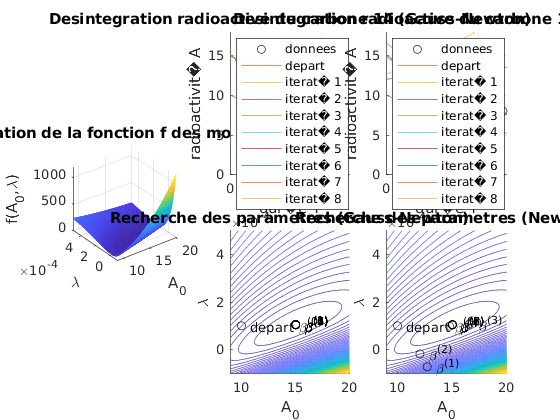

In [60]:
run("Modelisation_C14.m")

## Residu

$$r_i(A_0, \lambda) = A_i - A_0 e^{-\lambda t_i}$$

In [53]:
%%file residu_C14.m
%%------------------------------------------------------------------------%                                                                     %
% Fonction de calcul du residu de la fonction de desintegration           %
% radioactive du carbone 14                                               %
%-------------------------------------------------------------------------%
function res = residu_C14(beta, donnees)
%
% Paramètres en entrés
% --------------------
% beta : vecteur des paramètres
%         real(p)
% donnees : Données
%           real(n,2)
%
% Paramètres en sortie
% --------------------
% res    : vecteur des résidus
%          real(n)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    res = Ai - A0*exp(-lambda*ti);
end

Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/residu_C14.m'.


In [54]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [55]:
res = residu_C14(beta0, Donnees)


res =

       4.9877
       4.4516
       3.8127
       3.3918
       3.1968
       2.8347
       2.6741



```residu_C14(beta0, Donnees)
4.9877
4.4516
3.8127
3.3918
3.1968
2.8347
2.6741```

**OK**

## Jacobienne residu

$$ Jr(\beta)_{i,1} = \frac{\partial \big( A_i - A_0 e^{-\lambda t_i} \big) }{\partial A_0} = - e^{-\lambda t_i} $$
$$ Jr(\beta)_{i,2} = \frac{\partial \big( A_i - A_0 e^{-\lambda t_i} \big) }{\partial \lambda} = A_0 t_i \times e^{-\lambda t_i} $$


In [7]:
%%file J_residu_C14.m
%-------------------------------------------------------------------------%                                                                        %
% Fonction de calcul de la Jacobienne du residu de la fonction de         %
% desintegration radioactive du carbone 14                                %
%-------------------------------------------------------------------------%
function J_res = J_residu_C14(beta, donnees)
%
% Paramètres en entrés
% --------------------
% beta : vecteur des paramètres
%         real(p)
% donnees : Données
%           real(n,2)
%
% Paramètres en sortie
% --------------------
% J_res    : Matrice jacobienne des résidus
%            real(n,p)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    J_res(:, 1) = -exp(-lambda*ti);
    J_res(:, 2) = A0*ti.*exp(-lambda*ti);
end

Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/J_residu_C14.m'.


In [8]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [9]:
J_res = J_residu_C14(beta0, Donnees)


J_res =

     -0.95123       4756.1
     -0.90484       9048.4
     -0.81873        16375
     -0.74082        22225
     -0.67032        26813
     -0.60653        30327
     -0.53259        33553



```J_residu_C14(beta0, Donnees)
-0.95123 4756.1
-0.90484 9048.4
-0.81873 16375
-0.74082 22225
-0.67032 26813
-0.60653 30327
-0.53259 33553```

**OK**

## Hessienne residu (tenseur)

$$ \nabla^2 r(\beta)_{i,1,1} = \frac{\partial \big( - e^{-\lambda t_i} \big) }{\partial A_0} = 0 $$
$$ \nabla^2 r(\beta)_{i,1,2} = \frac{\partial \big( - e^{-\lambda t_i} \big) }{\partial \lambda} = \lambda e^{-\lambda t_i} $$
$$ \nabla^2 r(\beta)_{i,2,1} = \frac{\partial \big( A_0 t_i \times e^{-\lambda t_i} \big) }{\partial A_0} = t_i \times e^{-\lambda t_i} $$
$$ \nabla^2 r(\beta)_{i,2,2} = \frac{\partial \big( A_0 t_i \times e^{-\lambda t_i} \big) }{\partial \lambda} = -A_0 t_i \times t_i \times e^{-\lambda t_i} $$

In [10]:
%%file H_residu_C14.m
%-------------------------------------------------------------------------%                                                                        %
% Fonction de calcul de la Hessienne du residu de la fonction de         %
% desintegration radioactive du carbone 14                                %
%-------------------------------------------------------------------------%
function H_res = H_residu_C14(beta, donnees)
%
% Paramètres en entrés
% --------------------
% beta : vecteur des paramètres
%         real(p)
% donnees : Données
%           real(n,2)
%
% Paramètres en sortie
% --------------------
% H_res    : Matrice hessienne des résidus
%            real(n,p,p)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    H_res(:, 1, 1) = zeros(n, 1);
    H_res(:, 1, 2) = ti.*exp(-lambda*ti);
    H_res(:, 2, 1) = ti.*exp(-lambda*ti);
    H_res(:, 2, 2) = -A0*ti.*ti.*exp(-lambda*ti);
end

Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/H_residu_C14.m'.


In [11]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [12]:
H_res = H_residu_C14(beta0, Donnees)


H_res(:,:,1) =

            0       475.61
            0       904.84
            0       1637.5
            0       2222.5
            0       2681.3
            0       3032.7
            0       3355.3


H_res(:,:,2) =

       475.61  -2.3781e+06
       904.84  -9.0484e+06
       1637.5  -3.2749e+07
       2222.5  -6.6674e+07
       2681.3  -1.0725e+08
       3032.7  -1.5163e+08
       3355.3  -2.1139e+08



## Hessienne f: Matricielle

$$f(\beta)=\frac{1}{2} r(\beta)^{T} r(\beta)$$
$$\nabla f(\beta)= \nabla r(\beta)^{T} r(\beta)$$
$$\nabla^2 f(\beta)= \nabla^2 r(\beta)^{T} r(\beta) + \nabla r(\beta)^{T} \nabla r(\beta)$$

In [56]:
%%file Hess_f_C14_bis.m
%-------------------------------------------------------------------------%
% Fonction de calcul de la Hessienne des moindres carres de la fonction   %
% de desintegration radioactive du carbone 14                             %
% (residu et J_residu sont des fonctions en entree)                       %
%-------------------------------------------------------------------------%

function [H_f, res, J_res] = Hess_f_C14_bis(beta, donnees, residu, J_residu, H_residu)
%
% Paramètres en entrés
% --------------------
% beta     : vecteur des paramètres
%            real(p)
% donnees  : Données
%            real(n,2)
% residu   : fonction qui code les résidus
%            res = residus(beta)
% J_residu : fonction qui code la matrice jacobienne
%            J_res = J_residu(beta);
% H_residu : fonction qui code la matrice hessienne (ou plutôt derivée Jacobienne de Jacobienne)
%            H_res = H_residu(beta);
%
% Paramètres en sortie
% --------------------
% H_f      : Matrice hessienne
%            real(p,p)
% res      : vecteur des résidus
%            real(n)
% J_res    : Matrice jacobienne des résiduis
%            real(n,p)
%
    n = length(donnees);
    p = length(beta);
    res = residu(beta, donnees);
    J_res = J_residu(beta, donnees);
    H_res = H_residu(beta, donnees);
    K(:, :) = [res'*H_res(:,:,1); res'*H_res(:,:,2)];
    H_f = K + J_res'*J_res;
    %H_f = H_res'*res + J_res'*J_res;
end

Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/Hess_f_C14_bis.m'.


In [57]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [58]:
[H_f, res, J_res] = Hess_f_C14_bis(beta0, Donnees, @residu_C14, @J_residu_C14, @H_residu_C14);
H_f


H_f =

       4.0436       -50497
       -50497   1.8899e+09



```Hessienne f(beta^{(0)})
4.0436 -50497
-50497 1.8899e+09```

**OK**

$$\nabla^2 f(\beta)_{1,1} = \frac{\partial^2 f}{\partial \lambda^2} = \sum_{i=1}^{n} \left(-A_{0} t_{i} \times t_{i} \times e^{-\lambda t_{i}}\right) \times \left(A_{i}-A_{0} e^{-\lambda t_{i}}\right) + \left(A_{0} t_{i} \times e^{-\lambda t_{i}}\right) \times \left(A_{0} t_{i} \times e^{-\lambda t_{i}}\right) $$

$$\nabla^2 f(\beta)_{1,2} = \frac{\partial^2 f}{\partial \lambda \partial A_{0}} = \sum_{i=1}^{n} \left(t_{i} \times e^{-\lambda t_i}\right) \times \left(A_{i}-A_{0} e^{-\lambda t_{i}}\right) + \left(-e^{-\lambda t_i}\right) \times \left(A_{0}t_i\times e^{-\lambda t_i}\right) $$

$$\nabla^2 f(\beta)_{2,1} = \frac{\partial^2 f}{\partial A_0 \partial \lambda} = \sum_{i=1}^{n} \left(t_{i} \times e^{-\lambda t_i}\right) \times \left(A_{i}-A_{0} e^{-\lambda t_{i}}\right) + \left(-e^{-\lambda t_i}\right) \times \left(A_{0}t_i\times e^{-\lambda t_i}\right) $$

$$\nabla^2 f(\beta)_{2,2} = \frac{\partial^2 f}{\partial A_0^2} = \sum_{i=1}^{n} \left(- t_i \times e^{-\lambda t_i} \right) \times \left(- t_i \times e^{-\lambda t_i} \right) $$


In [16]:
%%file Hess_f_C14.m
%-------------------------------------------------------------------------%
% Fonction de calcul de la Hessienne des moindres carres de la fonction   %
% de desintegration radioactive du carbone 14                             %
% (residu et J_residu sont des fonctions en entree)                       %
%-------------------------------------------------------------------------%

function [H_f, res, J_res] = Hess_f_C14(beta, donnees, residu, J_residu)
%
% Paramètres en entrés
% --------------------
% beta     : vecteur des paramètres
%            real(p)
% donnees  : Données
%            real(n,2)
% residu   : fonction qui code les résidus
%            res = residus(beta)
% J_residu : fonction qui code la matrice jacobienne
%            J_res = J_residu(beta);
%
% Paramètres en sortie
% --------------------
% H_f      : Matrice hessienne
%            real(p,p)
% res      : vecteur des résidus
%            real(n)
% J_res    : Matrice jacobienne des résiduis
%            real(n,p)
%
    n = length(donnees);
    p = length(beta);
    ti = donnees(:, 1);
    Ai = donnees(:, 2);
    A0 = beta(1);
    lambda = beta(2);
    res = residu(beta);
    J_res = J_residu(beta);
    H_f(1, 1) = sum( (-exp(-lambda*ti)).*(-exp(-lambda*ti)) ); %lambda*lambda
    H_f(1, 2) = sum( (ti.*exp(-lambda*ti).*(Ai - A0*exp(-lambda*ti))) + (-exp(-lambda*ti).*(A0*ti.*exp(-lambda*ti))) ); %lambda*A0
    H_f(2, 1) = H_f(1, 2); %A0*lambda
    H_f(2, 2) = sum( (-A0*ti.*ti.*exp(-lambda*ti)).*(Ai - A0*exp(-lambda*ti)) + (A0*ti.*exp(-lambda*ti)).*(A0*ti.*exp(-lambda*ti)) ); %A0*A0
end

Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/Hess_f_C14.m'.


In [17]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [18]:
[H_f, res, J_res] = Hess_f_C14(beta0, Donnees, @(beta) residu_C14(beta, Donnees), @(beta) J_residu_C14(beta, Donnees));
H_f


H_f =

       4.0436       -50497
       -50497   1.8899e+09



## Algo Gauss Newton

$$\beta^{(k+1)}=\beta^{(k)}-\left[J_{r}\left(\beta^{(k)}\right)^{T} J_{r}\left(\beta^{(k)}\right)\right]^{-1} J_{r}\left(\beta^{(k)}\right)^{T} r\left(\beta^{(k)}\right)$$

In [34]:
%%file Algo_Gauss_Newton.m
function [beta, norm_grad_f_beta, f_beta, norm_delta, nb_it, exitflag] ...
          = Algo_Gauss_Newton(residu, J_residu, beta0, option)
%*****************************************************************
% Fichier  ~gergaud/ENS/Optim1a/TP-optim-20-21/TP-ref/GN_ref.m   *
% Novembre 2020                                                  *
% Université de Toulouse, INP-ENSEEIHT                           *
%*****************************************************************
%
% GN resout par l'algorithme de Gauss-Newton les problemes aux moindres carres
% Min 0.5||r(beta)||^2
% beta \in \IR^p
%
% Paramètres en entrés
% --------------------
% residu : fonction qui code les résidus
%          r : \IR^p --> \IR^n
% J_residu : fonction qui code la matrice jacobienne
%            Jr : \IR^p --> real(n,p)
% beta0 : point de départ
%         real(p)
% option(1) : Tol_abs, tolérance absolue
%             real
% option(2) : Tol_rel, tolérance relative
%             real
% option(3) : n_itmax, nombre d'itérations maximum
%             integer
%
% Paramètres en sortie
% --------------------
% beta      : beta
%             real(p)
% norm_gradf_beta : ||gradient f(beta)||
%                   real
% f_beta : f(beta)
%          real
% r_beta : r(beta)
%          real(n)
% norm_delta : ||delta||
%              real
% nbit : nombre d'itérations
%        integer
% exitflag   : indicateur de sortie
%              integer entre 1 et 4
% exitflag = 1 : ||gradient f(beta)|| < max(Tol_rel||gradient f(beta0)||,Tol_abs)
% exitflag = 2 : |f(beta^{k+1})-f(beta^k)| < max(Tol_rel|f(beta^k)|,Tol_abs)
% exitflag = 3 : ||delta)|| < max(Tol_rel*delta^k,Tol_abs)
% exitflag = 4 : nombre maximum d'itérations atteint
%      
% ---------------------------------------------------------------------------------

    %Initialisation:
    beta = beta0;
    r_beta = residu(beta);
    Jr_beta = J_residu(beta);
    
    norm_grad_f_beta0 = norm(Jr_beta'*r_beta, 2);
    f_beta = 0.5*r_beta'*r_beta;
    
    nb_it = 0;
    exitflag = 0;
    Tol_abs = option(1);
    Tol_rel = option(2);
    n_itmax = option(3);
    
    %Corps:
    while exitflag==0
        beta_old = beta;
        f_beta_old = f_beta;
        
        b = Jr_beta'*r_beta;
        A = Jr_beta'*Jr_beta;
        
        beta = beta - A\b; %MLDivide
        
        r_beta = residu(beta);
        Jr_beta = J_residu(beta);
        f_beta = 0.5*r_beta'*r_beta;
        
        nb_it = nb_it + 1;
        
        if norm(Jr_beta'*r_beta, 2) <= max(Tol_rel*norm_grad_f_beta0, Tol_abs)
            exitflag = 1;
        elseif abs(f_beta - f_beta_old) <= max(Tol_rel*abs(f_beta_old), Tol_abs)
            exitflag = 2;
        elseif norm(beta - beta_old) <= max(Tol_rel*norm(beta_old, 2), Tol_abs)
            exitflag = 3;
        elseif nb_it == n_itmax
            exitflag = 4;
        end
    end
    
    norm_grad_f_beta = norm(Jr_beta'*r_beta, 2);
    norm_delta = norm(beta-beta_old, 2);

end


Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/Algo_Gauss_Newton.m'.


In [35]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [36]:
%% Gauss-Newton
% -------------
% Initialisation de l'affichage
disp('Algorithme de Gauss-Newton')
disp('--------------------------------------------------------------------------------------------')
disp('     nb_iter         A0        lambda    ||f''(beta)||     f(beta)    ||delta||     exitflag ')
disp('--------------------------------------------------------------------------------------------')

% Calcul et affichage des valeurs initiales
res_beta = residu_C14(beta0, Donnees);
f_beta = 0.5*(res_beta.')*res_beta;
J_res_beta = J_residu_C14(beta0, Donnees);
norm_grad_f_beta = norm((J_res_beta.')*res_beta);
disp([0 beta0(1) beta0(2) norm_grad_f_beta f_beta]);

options = [sqrt(eps) 1.e-12 0];

for i = 1:nb_iterations_max
    txt_legend{i+2} = ['iterat� ' num2str(i)];
    options(3) = i;
    [beta, norm_grad_f_beta, f_beta, norm_delta, k, exitflag] = ...
    Algo_Gauss_Newton(@(beta) residu_C14(beta, Donnees), ...
                      @(beta) J_residu_C14(beta, Donnees), ...
                      beta0, options);
    disp([k beta(1) beta(2) norm_grad_f_beta f_beta norm_delta exitflag])
    % Visualisation
    A = beta(1)*exp(-beta(2)*T);
    %subplot(2, 3, 2)
    %plot(T,A)
    %legend(txt_legend{1:i+2})
    %  eval(['print -depsc fig_GN_courbe' int2str(i) '_C14'])
    %subplot(2, 3, 5)
    %plot(beta(1),beta(2),'ok')
    %text(beta(1),beta(2),['  \beta^{(' num2str(i) ')}'])
  
    pause(0.5)
end

% Affichage des itérés de beta et sauvegarde des graphique
disp('--------------------------------------------------------------------------------------------')

Algorithme de Gauss-Newton
--------------------------------------------------------------------------------------------
     nb_iter         A0        lambda    ||f'(beta)||     f(beta)    ||delta||     exitflag 
--------------------------------------------------------------------------------------------
            0           10       0.0001   4.6322e+05        48.07

  Columns 1 through 6

            1       15.022   0.00010633        15913      0.10507       5.0219

  Column 7

            4

  Columns 1 through 6

            2       15.025   0.00010433       5.9024     0.088621    0.0032964

  Column 7

            4

  Columns 1 through 6

            3       15.025   0.00010432      0.39911     0.088621   0.00068766

  Column 7

            4

  Columns 1 through 6

            4       15.024   0.00010432     0.004769     0.088621   4.9165e-06

  Column 7

            2

  Columns 1 through 6

            4       15.024   0.00010432     0.004769     0.088621   4.9165e-06

  Co

```--------------------------------------------------------------------------------------------
nb_iter A0 lambda ||f’(beta)|| f(beta) ||delta|| exitflag
--------------------------------------------------------------------------------------------
0 10 0.0001 4.6322e+05 48.07
1 15.022 0.00010633 15913 0.10507 5.0219 4
2 15.025 0.00010433 5.9024 0.088621 0.0032964 4
3 15.025 0.00010432 0.39911 0.088621 0.00068766 4
4 15.024 0.00010432 0.004769 0.088621 4.9165e-06 2
4 15.024 0.00010432 0.004769 0.088621 4.9165e-06 2
4 15.024 0.00010432 0.004769 0.088621 4.9165e-06 2
4 15.024 0.00010432 0.004769 0.088621 4.9165e-06 2
4 15.024 0.00010432 0.004769 0.088621 4.9165e-06 2```

## Algo Newton

$$ \beta^{(k+1)}=\beta^{(k)}-\left[S\left(\beta^{(k)}\right)+J_{r}\left(\beta^{(k)}\right)^{T} J_{r}\left(\beta^{(k)}\right)\right]^{-1} J_{r}\left(\beta^{(k)}\right)^{T} r\left(\beta^{(k)}\right) $$

In [47]:
%%file Algo_Newton.m
function [beta, norm_grad_f_beta, f_beta, norm_delta, nb_it, exitflag] ...
          = Algo_Newton(Hess_f_C14, beta0, option)
%************************************************************
% Fichier  ~gergaud/ENS/Optim1a/TP-optim-20-21/Newton_ref.m *
% Novembre 2020                                             *
% Université de Toulouse, INP-ENSEEIHT                      *
%************************************************************
%
% Newton résout par l'algorithme de Newton les problemes aux moindres carres
% Min 0.5||r(beta)||^2
% beta \in R^p
%
% Parametres en entrees
% --------------------
% Hess_f_C14 : fonction qui code la hessiennne de f
%              Hess_f_C14 : R^p --> matrice (p,p)
%              (la fonction retourne aussi le residu et la jacobienne)
% beta0  : point de dÃ©part
%          real(p)
% option(1) : Tol_abs, tolÃ©rance absolue
%             real
% option(2) : Tol_rel, tolÃ©rance relative
%             real
% option(3) : nitimax, nombre d'itÃ©rations maximum
%             integer
%
% Parametres en sortie
% --------------------
% beta      : beta
%             real(p)
% norm_gradf_beta : ||gradient f(beta)||
%                   real
% f_beta    : f(beta)
%             real
% res       : r(beta)
%             real(n)
% norm_delta : ||delta||
%              real
% nbit       : nombre d'itÃ©rations
%              integer
% exitflag   : indicateur de sortie
%              integer entre 1 et 4
% exitflag = 1 : ||gradient f(beta)|| < max(Tol_rel||gradient f(beta0)||,Tol_abs)
% exitflag = 2 : |f(beta^{k+1})-f(beta^k)| < max(Tol_rel|f(beta^k)|,Tol_abs)
% exitflag = 3 : ||delta)|| < max(Tol_rel delta^k),Tol_abs)
% exitflag = 4 : nombre maximum d'itÃ©rations atteint
%      
% ---------------------------------------------------------------------------------

    %Initialisation:
    beta = beta0;
    [Hf_beta, r_beta, Jr_beta] = Hess_f_C14(beta);
    
    norm_grad_f_beta0 = norm(Jr_beta'*r_beta, 2);
    f_beta = 0.5*r_beta'*r_beta;
    
    nb_it = 0;
    exitflag = 0;
    Tol_abs = option(1);
    Tol_rel = option(2);
    n_itmax = option(3);
    
    %Corps:
    while exitflag==0
        beta_old = beta;
        f_beta_old = f_beta;
        
        b = Jr_beta'*r_beta;
        A = Hf_beta;
        
        beta = beta - A\b; %MLDivide
        
        [Hf_beta, r_beta, Jr_beta] = Hess_f_C14(beta);
        f_beta = 0.5*r_beta'*r_beta;
        
        nb_it = nb_it + 1;
        
        if norm(Jr_beta'*r_beta, 2) <= max(Tol_rel*norm_grad_f_beta0, Tol_abs)
            exitflag = 1;
        elseif abs(f_beta - f_beta_old) <= max(Tol_rel*abs(f_beta_old), Tol_abs)
            exitflag = 2;
        elseif norm(beta - beta_old) <= max(Tol_rel*norm(beta_old, 2), Tol_abs)
            exitflag = 3;
        elseif nb_it == n_itmax
            exitflag = 4;
        end
    end
    
    norm_grad_f_beta = norm(Jr_beta'*r_beta, 2);
    norm_delta = norm(beta-beta_old, 2);
    
end



Created file '/home/jblancho/1A/optimisation/tp1/TP_Etudiants/Algo_Newton.m'.


In [48]:
Ti = [ 500; 1000; 2000; 3000; 4000; 5000; 6300];
Ai = [14.5; 13.5; 12.0; 10.8;  9.9;  8.9;  8.0];
Donnees = [Ti, Ai];
beta0 = [10; 0.0001];

In [49]:
%% Newton
% -------
% Initialisation de l'affichage
disp('Algorithme de Newton')
disp('--------------------------------------------------------------------------------------------')
disp('     nb_iter         A0        lambda    ||f''(beta)||     f(beta)    ||delta||     exitflag ')
disp('--------------------------------------------------------------------------------------------')

% Calcul et affichage des valeurs initiales
res_beta = residu_C14(beta0, Donnees);
f_beta = 0.5*(res_beta.')*res_beta;
J_res_beta = J_residu_C14(beta0, Donnees);
norm_grad_f_beta = norm((J_res_beta.')*res_beta);
disp([0 beta0(1) beta0(2) norm_grad_f_beta f_beta]);

options = [sqrt(eps) 1.e-12 0];

for i = 1:nb_iterations_max
    options(3) = i;
    % Algorithme de Newton
    [beta, norm_grad_f_beta, f_beta, norm_delta, k, exitflag] = ...
    Algo_Newton(@(beta) Hess_f_C14(beta, Donnees, ...
                                   @(beta) residu_C14(beta, Donnees), ...
                                   @(beta) J_residu_C14(beta, Donnees)), ...
                beta0, options);
    % Affichage des valeurs
    disp([k beta(1) beta(2) norm_grad_f_beta f_beta norm_delta exitflag])
    % Visualisation
    %A = beta(1)*exp(-beta(2)*T);
    %subplot(2, 3, 3)
    %plot(T,A)
    %legend(txt_legend{1:i+2})
    %subplot(2, 3, 6)
    %plot(beta(1),beta(2),'ok')
    %text(beta(1),beta(2),['  \beta^{(' num2str(i) ')}'])
  
    pause(0.5)
end

Algorithme de Newton
--------------------------------------------------------------------------------------------
     nb_iter         A0        lambda    ||f'(beta)||     f(beta)    ||delta||     exitflag 
--------------------------------------------------------------------------------------------
            0           10       0.0001   4.6322e+05        48.07

  Columns 1 through 6

            1       12.715   -7.255e-05   3.1785e+06       159.19       2.7154

  Column 7

            4

  Columns 1 through 6

            2       12.053  -1.8362e-05   9.7291e+05       34.783      0.66279

  Column 7

            4

  Columns 1 through 6

            3        16.55   0.00010635   2.1583e+05       4.2383       4.4973

  Column 7

            4

  Columns 1 through 6

            4       14.755   9.8263e-05       9600.9      0.14691       1.7953

  Column 7

            4

  Columns 1 through 6

            5       15.022   0.00010427       80.835     0.088626      0.26754

  Column 7

```--------------------------------------------------------------------------------------------
nb_iter A0 lambda ||f’(beta)|| f(beta) ||delta|| exitflag
--------------------------------------------------------------------------------------------
0 10 0.0001 4.6322e+05 48.07
1 12.715 -7.255e-05 3.1785e+06 159.19 2.7154 4
2 12.053 -1.8362e-05 9.7291e+05 34.783 0.66279 4
3 16.55 0.00010635 2.1583e+05 4.2383 4.4973 4
4 14.755 9.8263e-05 9600.9 0.14691 1.7953 4
5 15.022 0.00010427 80.835 0.088626 0.26754 4
6 15.024 0.00010432 0.0064489 0.088621 0.0023669 4
7 15.024 0.00010432 7.1168e-11 0.088621 1.8799e-07 1
7 15.024 0.00010432 7.1168e-11 0.088621 1.8799e-07 1
---------------------------------------------------------------------------------------```